# Project Overview

We conducted an experimental machine learning project.  We took a snapshot of data from the Solicitation Leads database and the Payoff database and combined them to create a more comprehensive view of our prediction subjects, which were mortgages with a chance of not being paid off.  Our goal was to give an indication which of these mortgages were most likely to payoff, and thus were the most rewarding mortages to pursue.

# Data
We joined two databases, LBP and Solicitations, by linking a shared variable, which was loankey.  We end up with a large dataset $(X, y)$, where $X$ denotes a vector of a training features and $y$ denotes the label or class for that feature vector.  We essentially want to go through and find a set of weights for each feature in $X$ that give us the highest accuracy in predicting the label $y$.  We use a library called **_pandas_** to store and manipulate data.

Below, we show an example of loading data into pandas. _data1_ holds all of our training data and the labels for this data.  _data2_ holds all of our test data and labels for that test.  We combine them into one single dataframe to create to easily manipulate all the data at once.  Below, you can see a sample of the data we work with.

In [10]:
# Here we load any library or function we will ever have to use for our purposes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import chi2, f_classif, SelectKBest, RFE, SelectFromModel
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data1 = pd.read_csv('Data/df_dropped.csv', engine='python')
data2 = pd.read_csv('Data/df_dropped_prediction.csv', engine='python')
df = pd.concat([data1, data2], axis=0)
print(data1.shape)
print(data2.shape)
print(df.shape)
df.head()

(429463, 137)
(13053, 137)
(442516, 137)


,BorrowerKey,BirthDt,PrimaryLanguageCD,FICO,FICODt,BKStatusCD,OrigFICO,OrigFICODt,BKStatusCDDesc,BKRemovalDesc,BKCompletionDt,BankruptcyStatusCode,IsDelinquent,BorrowerConsumerInfoCD,BorrowerConsumerInfoCDDesc,CreditBureauReportDt,CreditBureauCD,CreditBureauCDDesc,CreditBureauCommentCD,CreditBureauStatusCD,CreditBureauCommentCDDesc,CreditBureauCommentExpireDt,CreditBureauCDChangeDt,CreditBureauCDExpireDt,CreditBureauNegativeNoticeDt,CreditBureauOverrideCommentFlg,CreditBureauOverrideStatusFlg,CreditBureauStatusCDDesc,CreditBureauSuppressFlg,CreditBureauSuppressExpireDt,CreditBureauSuppressReasonCD,CreditBureauSuppressReasonCDDesc,FairCredCompCondCD,FairCredCompCondCDDesc,LoanKey,CurrentRate,LoType,CurrentTotalMonthlyPaymentAmt,OrigPrincipalBalanceAmt,LoanProduct,LoanMaturityDt,CurrentOptOutSolicitationCode,CurrentOptOutSolicitationDesc,CurrentOptOutSolicitationDt,NoteDt,CurrentPrincipalBalanceAmt,LoanPurposeCodeDesc,PoolNameKey,DMSolicitOK,LoanClosingDt,EMailSolicitOK,LoanModificationDt,VelocifySolicitOK,CPSolicitOK,LoanModificationCodeId,LoanModificationCodeDesc,FirstDueDt,PayoffDt,PayoffReasonCode,PayoffReasonDesc,PayoffStopCode,PayoffStopDesc,LoanAge,OriginalLoanToValueRatio,TradeID,AcquisitionDt,AcquisitionCode,DelinquentCodeByMonthString,DelinquentStatusCodeId,DelinquentStatusDesc,CalcLoanToValueRatio,BoardingDt,LossMitigationStatusCode,PayoffAmt,SubjectPropertyKey,PropertyCity,PropertyState,PropertyZip5,PropertyZip4,PropertyValueAmt,PropertyValueDt,OrigPropertyValueAmt,CurrentOccupancyStatusCD,CurrentOccupancyStatusDesc,OrigOccupancyStatusCD,PropertyTypeCD,PropertyTypeDesc,NumberofUnits,CAPropertyValueAmt,TrendixPropertyValueAmt,CalcPropertyValueAmt,loankey,Loan Number,Program,Lead Solicitation Type,Refirate,MonthlyPmtSav,NtbModel,RefiPIAmt,RefiMIAmt,RefiTotalPmt,RefiUpb,RefiTermYear,RefiTermMonths,RefiTotalPmt30,RefiMonthlyPmtSav30,IsFlex,Points,RunDate,IsDirectMail,IsCherryPie,CherryPieProg,Pool,PropertyPrice,MonthlyPmtSavPct,MarketingChannels,IsVelocify,IsEmail,LeadScore,MailWeek,DmCampaignName,MIPRateReduction,PmtSav_100,PE_100,LoanProgram_100,IsLead_100,PmtSavPct_100,RefiRate_100,DebtConsolidationFlag,EstimatedDebt,EstimatedPmtOnDebt,ExptBucket,EstimatedLtv,EmploymentFilterFlag,Post_PE_NEC_RA,CashoutAmount,CostOfCashout
0,9179677.0,NaN,,NaN,NaN,NaN,752.0,1/25/2013,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,3,Transaction 021(D-001) (name/address change) g...,NaN,11,NaN,NaN,3/6/2013,NaN,NaN,NaN,NaN,LOAN CURRENT,NaN,NaN,NaN,NaN,NaN,NaN,5489383.0,0.03500,3.0,1376.95,211000.0,Conv,2/1/2043,NaN,NaN,NaN,1/25/2013,186251.77,REFINANCE/NO CASH OUT,13.0,1.0,1/30/2013,1.0,NaN,1.0,1.0,NaN,NaN,3/1/2013,NaN,NaN,NaN,0.0,NONE,51.0,0.000,NaN,NaN,1.0,0,P,PREPAID OR CURRENT,55.0,1/30/2013,NaN,NaN,5234399.0,WHITE PLAINS,MD,20695.0,NaN,268000.0,1/30/2013,0.0,1.0,ORIGINAL OWNER,1.0,1.0,SINGLE FAMILY DETACHED,NaN,336000.0,248077.41,336000.00,5489383.0,7.000029e+09,Conventional 30,Cashout,0.04380,-354.370000,Cashout,1301.850000,0.000000,1301.850000,260742.00000,30.0,360.0,0.000000,0.000000,NaN,-0.002500,6/1/2017,1.0,1.0,Conventional 30,Other,336000.00000,-0.374011,All,1.0,1.0,-4785.836650,4.0,Cashout,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.0,0.776018,0.0,NaN,72065.0,0.06641
1,9155656.0,NaN,,NaN,NaN,NaN,NaN,6/19/2015,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,3,Transaction 021(D-001) (name/address change) g...,NaN,11,NaN,NaN,9/8/2016,NaN,10/5/2016,NaN,NaN,LOAN CURRENT,N,NaN,NaN,NaN,NaN,NaN,5512082.0,0.03875,1.0,2045.59,322547.0,FHA,7/1/2045,NaN,NaN,NaN,6/19/2015,311596.52,REFINANCE/NO CASH OUT,13.0,1.0,6/24/2015,1.0,NaN,1.0,1.0,NaN,NaN,8/1/2015,NaN,NaN,NaN,0.0,NONE,22.0,0.980,NaN,6/24/2015,1.0,101010100,D,16-29 DAYS DELINQUENT,83.0,6/25/2015,NaN,NaN,5966442.0,MOSELEY,VA,23120.0,NaN,329213.0,6/24/2015,329213.0,1.0,ORIGINAL OWNER,1.0,8.0,PUD,1.0,376000.0,337047.71,376000.00,5512082.0,7.000602e+09,FHA Streamline 30,FHA Streamline,0.03375,119.133330,Constellation,1407.986846,212.319824,1620.306670,318479.73650,30.0,360.0,1620.306670,119.133330,0.0,-0.008428,9/14/2016,1

### Data Filling
Notice that the data sample features _NaNs_. _NaNs_ are empty values that must be replaced or otherwise dealt with in order for data processing to proceeds.  

How do we deal with these values? Some feature columns can drop, because they consist of nearly entirely null values. _BankruptcyStatusCode_ is an example of this  Other value, such as _OrigFICO_, we can replace with the median value.  Others, _BorrowerConsumerInfoCD_, we mark that the value was _NaN_ by some other variable.  

### Feature Engineering
We are not limited to the data given to us.  We can derive and create new features given our understanding of the data's relationships.  For example, we have the columns _LoanClosingDt_, _LoanMaturityDt_, and _LoanAge_.  We can create a new column called _LoanTermRemaining_ by taking the difference between _LoanClosingDt_ and _LoanMaturityDt_, and subtracting the _LoanAge_ from the total time of the loan.

Examples of these are shown below.  Note that other forms of data engineering were utilized, this is just a sample.

In [3]:
# dropping a column of mostly NaNs
df.drop(["BankruptcyStatusCode"], axis=1, inplace=True)

# Replacing missing values with the median
df['OrigFICO'].fillna(df['OrigFICO'].median(), inplace=True)

# Replacing with missing values with its own variable
df['BorrowerConsumerInfoCD'].fillna("O", inplace=True)

# Feature Engineering with dates
df['LoanClosingDt'] = pd.to_datetime(df['LoanClosingDt'])
df['LoanMaturityDt'] = pd.to_datetime(df['LoanMaturityDt'])
df['LoanTermMonths'] = ((df['LoanMaturityDt'] - df['LoanClosingDt']) / np.timedelta64(1, 'M')).astype('int')
df['LoanTermRemaining'] = df['LoanTermMonths'] - df['LoanAge']

# Algorithms
This was a supervised machine learning problem, meaning we had a clearly defined answer we are trying to solve for.  We settled on three likely machine learning algorithms that could help us.

### Logistic Regression

![logistic](https://media.licdn.com/mpr/mpr/AAEAAQAAAAAAAAkUAAAAJDJlMDNjMGM5LTlmZjktNDlhNy1iNmNmLTE5NTM1YjE3NzA0Yw.png)

In a simple sense, Logistic Regression is essentially drawing a line between two different groups of classes.  It attempts to find a division that most cleanly separates both classes.  This depicts a logistic regression with two features and two classes.  Our dataset's dimensionality is much greater, given we have so many more features to use, making it virtually impossible to visualize.  Logistic Regression will automatically find the best weights that can describe a line that best separates between each class.

Logistic Regression is one of the primary algorithms we explored and used to create models.  We used **_scikit-learn_** to create our Logistic Regression Models.


### Decision Trees/Random Forests
![forest](http://www.thefactmachine.com/wp-content/uploads/2014/05/RF-ConstructTree.jpg)

Decision Trees split data based on internally defined heuristics(characteristics of the data) and what brings each tree closer to a decision.  The leaf nodes at the bottom of each tree represent the decision each tree arrived at.

Decision Trees turned out to be a great model for our data, because certain features were able to indicate to the algorithm that this was a key feature in determining payoffs (i.e. if a person was delinquent, he would be less likely to pay off a mortgage.  We used **_scikit-learn_** to create our Random Forest Models.

### Neural Networks
![neural](http://neuralnetworksanddeeplearning.com/images/tikz12.png)

Although Neural Netowrks are all the rage nowadays, neural networks are simply functions that can model any arbitrary function.  That is, it theoretically model itself it fit any data possible.  It trains itself by adjusting weights in inner nodes and computing the error of how wrong it was.  

Neural Networks were not used very much in our work, because of the time it takes to implement and tune a neural network, as well as discovering why Decision Trees work better for our data.  However, in the future it would be prudent to go back and recreate our models with neural nets, because they theoretically should have equal or greater performance.



# Project

### Tools

1. Jupyter Notebook
![jupyter](https://avatars3.githubusercontent.com/u/7388996?v=4&s=400)
    - Jupyter Notebook is a free open source tool that allows you to write and execute code, while providing an easy way to visulaize data and graphs.  It is much simpler, faster, and easier to use than any proprietary tools that this company may want to use or buy in the future, so I would highly recommend using  Jupyter Notebook for any data visulization projects later on.
    - It is a reimplementation of MatLab tools, but has grown beyond that now and is much more powerful.  I would highly recommend using Jupyter Notebook and related data science tools in Python in the future.
    - This presentation was built was Jupyter Notebook, to help inline code segments.  Jupyter Notebooks can produce nicely formatted PDF files, LaTex Files, HTML files, Markdown Files, and python code itself.
2. NumPy
![numpy](https://bids.berkeley.edu/sites/default/files/styles/400x225/public/projects/numpy_project_page.jpg?itok=flrdydei)
    - Numerical Computation Library that forms the backbone of all data science and analysis tools in Python.  As the result of decades of computer science research, it is on the cutting edge of speed and numerical accuracy while performing massive computations.  NumPy is what allows our models to finish training in a reasonable time.
3. Pandas
![pandas](http://www.logilab.org/file/203841/raw/pandas_logo.png)
    - Pandas is a library built on top of NumPy that allows ease of data structure manipulation and can handle extremely large amounts of data with ease.  Anything Excel can do, Pandas can do for you in one or two lines of code and can do it faster too.  This project initially started out manipulating data on Excel, but due to frequent crashes, I shifted over to a pure Pandas way of manipulaint data.
4. MatplotLib
![matplotlib](https://matplotlib.org/1.3.1/_static/logo2.png)
    - Matplotlib allows plotting of graphs, and can create anything from simple bar graphs to 3D plots of terrain and anything in between.  
![matplotlibgraph](http://matplotlib.org/_images/demo_mplot3d.png)
5. SciPy
![scipy](http://www.leouieda.com/images/thumb/scipy2017-proposal-gmt.png)
    - Library of scientific data tools in Python, built on top of NumPy.  Wroth mentioning in that it gives you many vector wise computations that significantly make life easier.
6. Scikit-Learn
![scikit-learn](http://www.scipy-lectures.org/_images/scikit-learn-logo.png)
    - Machine Learning Library built on top of all the libraries and frameworks built above.  Gives machine learning functions that are extremely tunable and relatively easy to use.  Allows you to easily prototype your models, and gives you a foundation to create your own algorithms in the future for production use or something similiar.  Here, we used our Random Forest and Logistic Regression algorithms, in addition to other tools to calculate costs and select hyper parameters of algorithms.

### Continuing Hackathon Results
When I first got to PennyMac, I was given a limited dataset from the hackathon machine learning project.  By optimizing the parameters of the learning functions and the data, I was able to boost the accuracy rate from 80% to 88% or more.  After a week, I was given access to an entire database and when we first ran the algorithm... we got 99.9% accuracy!

### Data Check
It turns out that when a loan is paid off, certain values would be set.  Often times, certain feature values would map 1-1 to the class label.  Essentially, we had been feeding the answer into the algorithm to predict that answer.  This bagan a long trial and error process, where we would remove columns that we saw were giving away the answer, and rerun these algorithms.  

Additionally, we found that our models may predict fairly highly when given data of similiar years, but much more poorly when given data that is from different years (i.e. we may train on data from 2016, but predicting on labels from 2017 will experience a great drop in accuracy).  We are currently still investigating why predicting farther off data results in a drop in accuracy (is there still a column that is giving away the answer for only 2016?)

### Procedure
This is the procedure to testing and applying a model.  In our example, we will be using a Random Forest classifier.
We first load the data into pandas and split the data into training data and test data, then split each into feature sets and label sets.

In [4]:
df = pd.read_csv('Data/LBP_dummified_data.csv')
df2 = pd.read_csv('Data/LBP_dummified_data_prediction.csv')
X_train = df.drop(['PayoffStopDesc'], axis=1)
y_train = df['PayoffStopDesc']
X_test = df2.drop(['PayoffStopDesc'], axis=1)
y_test = df2['PayoffStopDesc']

In [15]:
print(df.shape)
print(df2.shape)

(397669, 294)
(26106, 294)


We then define our model, in this case a Random Forest.  The paramters passed in for the Random Forest are chosen to maximize the accuracy of the model.  In theory, we could choose these hypterparameters through GridSearch(by creating a model and trying every possiblity of hypter parameters).  

In [5]:
parameters = {
        'bootstrap': False, 
        'criterion': 'gini', 
        'max_depth': None, 
        'max_features': 'sqrt', 
        'min_samples_leaf': 50, 
        'min_samples_split': 10, 
        'n_estimators': 500, 
        'random_state': 1, 
        'warm_start': True,
        'n_jobs': -1
    }
model = RandomForestClassifier(**parameters)

We then define a function to cross-validate our training results.  We cross-validate with a fold of 5, creating 5 different models with 5 different views of the data.  This gives us an average of the cross-validation accuracy.

We cross-validate to ensure that our algorithm is along the right path, and that it can predict from data it has learned reasonably well.  (If it can't predict well on data it has learned, it could never predict well on data it has never seen before)

After cross validation we then train on all of the training data, and score the model by passing in new data to predict on.

In [6]:
# Cross-Validation
def compute_score(model, X, y, scoring='accuracy'):
    xval = cross_val_score(model, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)
print(compute_score(model, X_train, y_train))

# Train, then predict
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print(score)

0.867118058234
0.558224163028


We see that our cross-validation is at 86%, yet the test score is 30% lower.  This indicates a form of overfitting.
We can try to combat this by messing with our data a bit more (making the test set split align more with the training set)

Now that our model is somewhat trained, we decide to see if it is possible to train the function to be somewhat better.  If we can reduced the number of columns, then the model would have less features to weigh and focus on the best features.  We can illustrate the best features with a bar graph

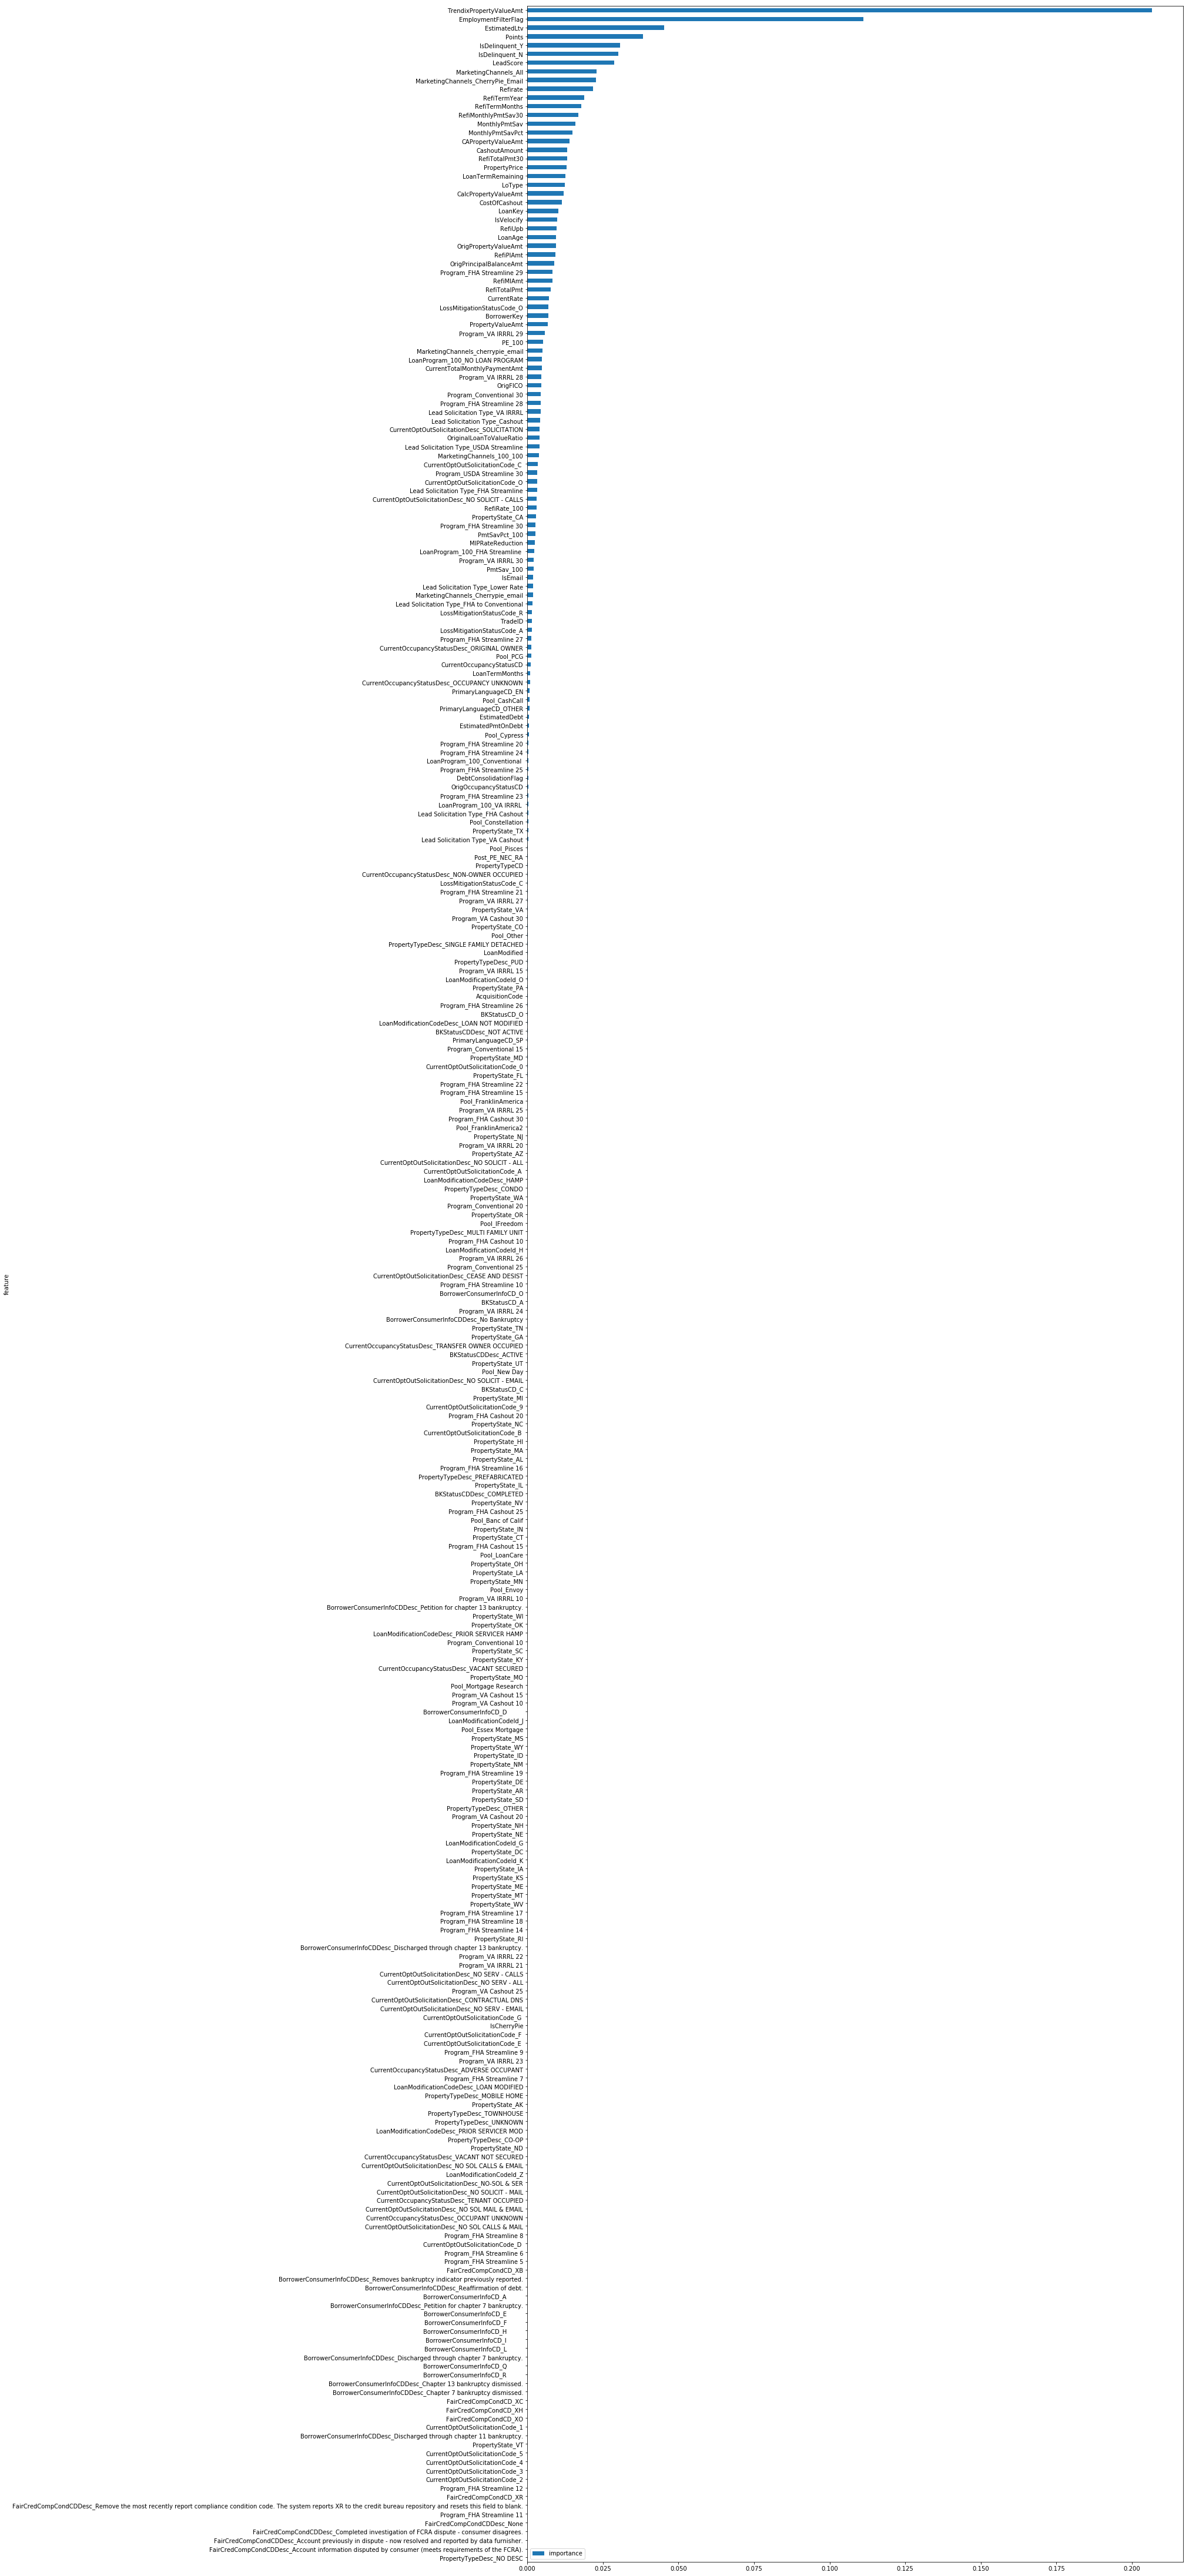

In [7]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'],ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20,80))

Although hard to see, we can see that many of the features have no relevance to predicting labels correctly.  We should get rid of these data columns, because they extend training time, add noise to data, and make life more difficult in general.  Since we now have a trained model, we can apply our model to the data and reduce the data feature set to only the relevant features.

In [11]:
# Reducing dimensionality of features
best = SelectFromModel(model, prefit=True)
feature_idx = best.get_support()
feature_names = X_train.columns[feature_idx]

X_train_reduced = best.transform(X_train)
X_train_reduced = pd.DataFrame(X_train_reduced, columns=feature_names)

X_test_reduced = best.transform(X_test)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=feature_names)
print(X_train_reduced.shape)
print(X_test_reduced.shape)

(397669, 53)
(26106, 53)


We initally had 294 features, but now we have reduced it to 53.  After reducing the feature set, we train our model again on this new reduced feature set.

In [12]:
parameters = {
        'bootstrap': False, 
        'criterion': 'gini', 
        'max_depth': None, 
        'max_features': 'sqrt', 
        'min_samples_leaf': 50, 
        'min_samples_split': 10, 
        'n_estimators': 500, 
        'random_state': 1, 
        'warm_start': True,
        'n_jobs': -1
    }
model = RandomForestClassifier(**parameters)
model.fit(X_train_reduced, y_train)
score = model.score(X_test_reduced, y_test)
print(score)

0.557879414694


We can see the score 55%.  Next we should look at the feature relevance, to see if they changed after being reduced and trained upon again.  We plot another bar graph of the importance of each feature.

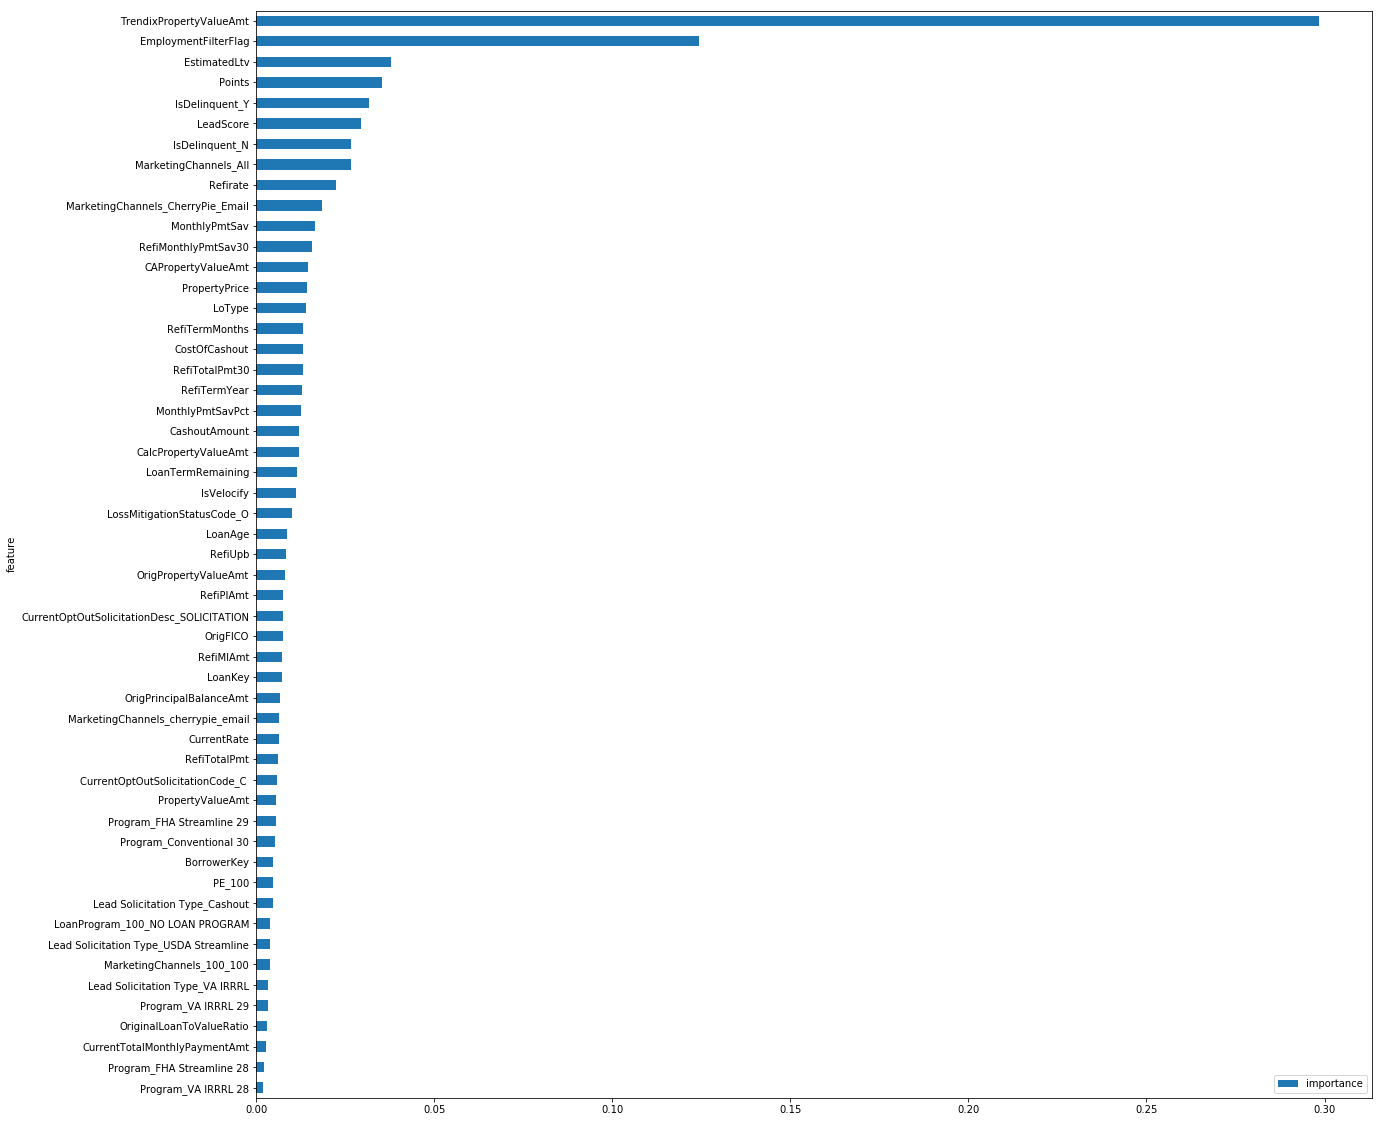

In [13]:
features = pd.DataFrame()
features['feature'] = X_train_reduced.columns
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'],ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(20,20))

We should save our model outputs for analysis later and for distribution.  We save both the graph of importances and the probabilities predicted for each label.

In [14]:
output_predict = model.predict(X_test_reduced) #Predict on the test set
output_prob = model.predict_proba(X_test_reduced) #Get back probabilities of the test set
df_output = pd.DataFrame()
df_output = pd.concat([X_test_reduced, y_test], axis=1)
df_output["Predictions"] = output_predict
df_output["Predictions_Probabilities_N"] = output_prob[:,0]
df_output["Predictions_Probabilities_Y"] = output_prob[:,1]
df_output.to_csv('PredictedData/FullRandomForestProbs.csv', index=False)
features.to_csv('PredictedDataImportances/FullRandomForestImportances.csv', index=False)

# Looking Towards The Future
### Time-Series Problem
Because this is a time-series problem (we take data and look at how it would do 6 months in the future), it would be best to generate new training data every 6 months and run more predictions.  This way over time, the algorithm could become more accurate

Additionally, this project and future projects would go much smoother if access to data was not so limited and information was more freely distributed.